In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Although we split manually by time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import warnings

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [17]:
print("Starting data loading process...")
# <<< --- IMPORTANT: SET YOUR FILE PATH HERE --- >>>
file_path = r"C:\Users\User\Downloads\UMHackathon2025\data\merged_btc_price_flow_data.csv"
# <<< --- IMPORTANT: SET YOUR FILE PATH HERE --- >>>

try:
    df = pd.read_csv(file_path)
    print(f"Original data shape: {df.shape}")
    print("\nFirst 5 rows of original data:")
    print(df.head())
    print("\nData Info:")
    df.info()
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please update the 'file_path' variable in the cell above.")
    # Stop execution if file not found
    raise

Starting data loading process...
Original data shape: (2433121, 13)

First 5 rows of original data:
             Timestamp     Open     High      Low    Close     Volume  \
0  2020-04-09 00:00:00  7311.27  7328.04  7311.27  7328.04   7.907567   
1  2020-04-09 00:01:00  7324.97  7332.48  7323.85  7326.89   5.357228   
2  2020-04-09 00:02:00  7329.96  7347.66  7329.96  7342.84  14.179910   
3  2020-04-09 00:03:00  7342.84  7347.68  7339.99  7345.00   5.050320   
4  2020-04-09 00:04:00  7347.59  7347.60  7334.80  7338.53   0.607997   

                    datetime  start_time  blockheight  flow_mean  flow_total  \
0  2020-04-09 00:00:00+00:00         NaN          NaN        NaN         NaN   
1  2020-04-09 00:01:00+00:00         NaN          NaN        NaN         NaN   
2  2020-04-09 00:02:00+00:00         NaN          NaN        NaN         NaN   
3  2020-04-09 00:03:00+00:00         NaN          NaN        NaN         NaN   
4  2020-04-09 00:04:00+00:00         NaN          NaN        

In [18]:
num_rows_to_keep = 2000000
if len(df) > num_rows_to_keep:
    print(f"Reducing dataset to the last {num_rows_to_keep} rows.")
    df = df.iloc[-num_rows_to_keep:]
    print(f"Reduced data shape: {df.shape}")
else:
    print("Dataset size is within the limit, no reduction needed.")
# --------------------------

Reducing dataset to the last 2000000 rows.
Reduced data shape: (2000000, 13)


In [19]:
print("Converting timestamp and setting index...")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True) # Ensure data is chronologically sorted
print("Timestamp converted and set as index.")
print(df.head())

Converting timestamp and setting index...
Timestamp converted and set as index.
                         Open      High       Low     Close     Volume  \
Timestamp                                                                
2021-02-03 19:41:00  36463.09  36498.58  36451.74  36491.41  12.203335   
2021-02-03 19:42:00  36492.99  36498.99  36473.86  36483.14   1.702440   
2021-02-03 19:43:00  36486.88  36506.54  36467.46  36498.21   0.774292   
2021-02-03 19:44:00  36503.38  36524.60  36493.98  36513.30   2.207146   
2021-02-03 19:45:00  36518.91  36523.73  36447.36  36448.02   1.139316   

                                      datetime    start_time  blockheight  \
Timestamp                                                                   
2021-02-03 19:41:00  2021-02-03 19:41:00+00:00  1.612380e+12     668944.0   
2021-02-03 19:42:00  2021-02-03 19:42:00+00:00  1.612380e+12     668944.0   
2021-02-03 19:43:00  2021-02-03 19:43:00+00:00  1.612380e+12     668944.0   
2021-02-03 19:44

In [20]:
print("Cleaning the data...")

# Convert relevant columns to numeric, coercing errors to NaN
for col in df.columns:
    # Skip non-numeric columns that we know shouldn't be converted
    if col in ['datetime']: # 'regime' is handled separately below if it exists
        continue

    # Only attempt conversion if not already numeric
    if not pd.api.types.is_numeric_dtype(df[col]):
         try:
             df[col] = pd.to_numeric(df[col], errors='coerce')
             print(f"Converted column '{col}' to numeric.")
         except Exception as e:
             print(f"Could not convert column {col} to numeric: {e}")

# Define flow columns specifically for NaN filling
flow_cols = ['start_time', 'blockheight', 'flow_mean', 'flow_total', 'transactions_count_flow', 'regime']
existing_flow_cols = [col for col in flow_cols if col in df.columns] # Only use columns that exist

# Fill NaN values in flow features with forward fill (or 0 if no previous value)
print(f"Forward filling NaNs in columns: {existing_flow_cols}")
df[existing_flow_cols] = df[existing_flow_cols].fillna(method='ffill')

# If there are still NaN values at the beginning (before first valid entry), fill with 0
print("Filling any remaining NaNs at the start of flow columns with 0...")
df[existing_flow_cols] = df[existing_flow_cols].fillna(0)

# Check for NaN values after initial cleaning
print("\nNaN count by column after initial cleaning (showing columns with NaNs):")
nan_check = df.isna().sum()
print(nan_check[nan_check > 0])

Cleaning the data...
Forward filling NaNs in columns: ['start_time', 'blockheight', 'flow_mean', 'flow_total', 'transactions_count_flow', 'regime']
Filling any remaining NaNs at the start of flow columns with 0...

NaN count by column after initial cleaning (showing columns with NaNs):
Series([], dtype: int64)


In [21]:
print("Performing feature engineering...")

# 1. Price-based features
df['Returns'] = df['Close'].pct_change()

# Moving Averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# MACD (Moving Average Convergence Divergence)
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Create target variable (predicting next minute's direction)
df['Target_Return'] = df['Returns'].shift(-1) # Next period's return
df['Target_Direction'] = np.where(df['Target_Return'] > 0, 1, 0) # 1 if price goes up, 0 otherwise

print("Feature engineering complete.")
print("\nColumns after feature engineering:")
print(df.columns)
print("\nData head with new features:")
print(df.head())
print("\nData tail (showing target variable calculation):")
print(df.tail())


Performing feature engineering...
Feature engineering complete.

Columns after feature engineering:
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'datetime', 'start_time',
       'blockheight', 'flow_mean', 'flow_total', 'transactions_count_flow',
       'regime', 'Returns', 'MA5', 'MA20', 'EMA12', 'EMA26', 'MACD',
       'MACD_Signal', 'Target_Return', 'Target_Direction'],
      dtype='object')

Data head with new features:
                         Open      High       Low     Close     Volume  \
Timestamp                                                                
2021-02-03 19:41:00  36463.09  36498.58  36451.74  36491.41  12.203335   
2021-02-03 19:42:00  36492.99  36498.99  36473.86  36483.14   1.702440   
2021-02-03 19:43:00  36486.88  36506.54  36467.46  36498.21   0.774292   
2021-02-03 19:44:00  36503.38  36524.60  36493.98  36513.30   2.207146   
2021-02-03 19:45:00  36518.91  36523.73  36447.36  36448.02   1.139316   

                                      datetime   

In [22]:
print("Filling remaining NaN values...")
# NaNs from rolling calculations are at the beginning
# NaN from target shift is at the end

# Use fillna with 'ffill' first to propagate last valid observation forward
df.fillna(method='ffill', inplace=True)
# Use fillna with 'bfill' to fill any NaNs at the very beginning
df.fillna(method='bfill', inplace=True)
# As a final safeguard, fill any remaining NaNs with 0 (shouldn't be necessary after ffill/bfill if data exists)
df.fillna(0, inplace=True)

# Drop rows where target is NaN (the very last row due to shift(-1))
# Also drops rows at the beginning where features couldn't be calculated if bfill didn't cover them
initial_rows = len(df)
df.dropna(inplace=True) # Primarily removes the last row with NaN target
final_rows = len(df)
print(f"Dropped {initial_rows - final_rows} rows due to NaN values (likely the last row from target shift and initial rows from rolling features).")


print(f"\nData shape after all preprocessing: {df.shape}")
print("\nFinal check for any remaining NaNs:")
print(df.isna().sum().sum()) # Should be 0

Filling remaining NaN values...
Dropped 0 rows due to NaN values (likely the last row from target shift and initial rows from rolling features).

Data shape after all preprocessing: (2000000, 21)

Final check for any remaining NaNs:
0


In [23]:
feature_columns = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'Returns', 'MA5', 'MA20', 'MACD', 'MACD_Signal'
]

# Add flow columns if they exist in the dataframe and have no NaNs after cleaning
print("Checking for flow columns to add as features...")
flow_features_to_add = ['flow_mean', 'flow_total', 'transactions_count_flow', 'regime']
for col in flow_features_to_add:
    if col in df.columns:
        if df[col].isna().sum() == 0:
            feature_columns.append(col)
            print(f" - Added '{col}'")
        else:
             print(f" - Warning: Column '{col}' exists but still contains NaNs, not adding.")
    else:
        print(f" - Column '{col}' not found in dataframe.")


print(f"\nFinal features being used ({len(feature_columns)}): {feature_columns}")

# Sanity check: Ensure all selected features exist and have no NaNs
missing_cols = [col for col in feature_columns if col not in df.columns]
if missing_cols:
    print(f"\nError: The following selected features are missing from the DataFrame: {missing_cols}")
    raise ValueError("Missing feature columns")

nan_in_features = df[feature_columns].isna().sum()
if nan_in_features.sum() > 0:
     print(f"\nError: NaNs found in selected feature columns:\n{nan_in_features[nan_in_features > 0]}")
     raise ValueError("NaNs found in feature columns")
else:
     print("\nConfirmed: All selected features exist and contain no NaNs.")

Checking for flow columns to add as features...
 - Added 'flow_mean'
 - Added 'flow_total'
 - Added 'transactions_count_flow'
 - Added 'regime'

Final features being used (14): ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA5', 'MA20', 'MACD', 'MACD_Signal', 'flow_mean', 'flow_total', 'transactions_count_flow', 'regime']

Confirmed: All selected features exist and contain no NaNs.


In [24]:
X = df[feature_columns].values
y = df['Target_Direction'].values

print("X (features) shape:", X.shape)
print("y (target) shape:", y.shape)

# Scale features
# Use StandardScaler - more robust to outliers than MinMaxScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)
print("\nScaling complete.")
# Note: We keep the scaler object as it's needed to transform new data later.

X (features) shape: (2000000, 14)
y (target) shape: (2000000,)
X_scaled shape: (2000000, 14)

Scaling complete.


In [25]:
train_size = int(len(X_scaled) * 0.8)
test_size = len(X_scaled) - train_size

X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print("Train/Test split complete.")


Training set size: 1600000 samples
Testing set size: 400000 samples
Train/Test split complete.


In [26]:
def create_sequences(X, y, time_steps=10):
    """
    Creates sequences of data for LSTM.
    Input X shape: (n_samples, n_features)
    Input y shape: (n_samples,)
    Output Xs shape: (n_samples - time_steps, time_steps, n_features)
    Output ys shape: (n_samples - time_steps,)
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)]) # Sequence of features
        ys.append(y[i + time_steps])     # Target for the end of the sequence
    return np.array(Xs), np.array(ys)


In [27]:
time_steps = 10 # Define the lookback period

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

print(f"Training sequences shape: {X_train_seq.shape}") # (samples, time_steps, features)
print(f"Training targets shape: {y_train_seq.shape}")
print(f"Testing sequences shape: {X_test_seq.shape}")
print(f"Testing targets shape: {y_test_seq.shape}")

# Determine input size for LSTM based on the number of features
input_size = X_train_seq.shape[2]
print(f"\nInput size (number of features) for LSTM: {input_size}")

Training sequences shape: (1599990, 10, 14)
Training targets shape: (1599990,)
Testing sequences shape: (399990, 10, 14)
Testing targets shape: (399990,)

Input size (number of features) for LSTM: 14


In [28]:
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq).unsqueeze(1) # Target needs shape (batch, 1) for BCELoss
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq).unsqueeze(1) # Target needs shape (batch, 1)

print("Tensor shapes:")
print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")
print(f"X_test_tensor: {X_test_tensor.shape}")
print(f"y_test_tensor: {y_test_tensor.shape}")

Tensor shapes:
X_train_tensor: torch.Size([1599990, 10, 14])
y_train_tensor: torch.Size([1599990, 1])
X_test_tensor: torch.Size([399990, 10, 14])
y_test_tensor: torch.Size([399990, 1])


In [29]:
batch_size = 256 # Increased from original 128 for potentially faster training on large data

# Training DataLoader (shuffle=True is important)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing DataLoader (shuffle=False to maintain order for evaluation/plotting)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created with batch size: {batch_size}")
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

DataLoaders created with batch size: 256
Number of batches in train_loader: 6250
Number of batches in test_loader: 1563


In [30]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        # batch_first=True makes input/output tensors have shape (batch, seq, feature)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)

        # Optional: Add Batch Normalization after LSTM
        # self.bn1 = nn.BatchNorm1d(hidden_size)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2) # Example: Reduce dimension
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.sigmoid = nn.Sigmoid() # Sigmoid for binary classification (output between 0 and 1)

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_size)

        # Initialize hidden state and cell state with zeros
        # Shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        # out shape: (batch_size, time_steps, hidden_size)
        # hn, cn are the final hidden and cell states
        out, _ = self.lstm(x, (h0, c0))

        # We only need the output from the last time step
        # out shape: (batch_size, hidden_size)
        out = out[:, -1, :]

        # Optional: Apply Batch Normalization
        # out = self.bn1(out)

        # Pass through fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out) # Apply sigmoid activation

        # out shape: (batch_size, 1)
        return out

print("LSTMModel class defined.")

LSTMModel class defined.


In [31]:
hidden_size = 64  # Number of features in hidden state (adjust as needed)
num_layers = 2    # Number of stacked LSTM layers (adjust as needed)
output_size = 1   # Single output: probability of price going up
dropout_prob = 0.3 # Dropout probability (adjust as needed)

# Learning Rate for optimizer
learning_rate = 0.001

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
print("\nModel Architecture:")
print(model)

# Loss function: Binary Cross Entropy Loss for binary classification
criterion = nn.BCELoss()

# Optimizer: Adam is a popular choice
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"\nLoss function: {criterion}")
print(f"Optimizer: Adam with lr={learning_rate}")

Using device: cpu

Model Architecture:
LSTMModel(
  (lstm): LSTM(14, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Loss function: BCELoss()
Optimizer: Adam with lr=0.001


In [32]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train() # Set model to training mode
    train_losses = []
    print("\n--- Starting Training ---")
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            # Optional: Gradient Clipping (helps prevent exploding gradients)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) # Accumulate loss weighted by batch size

            # Calculate accuracy for the batch
            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Print progress every N batches
            if (batch_idx + 1) % 100 == 0:
                 print(f'  Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Batch Loss: {loss.item():.4f}')

        epoch_loss = running_loss / total_samples
        epoch_acc = correct_predictions / total_samples
        train_losses.append(epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}] COMPLETE: Avg. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    print("--- Training Finished ---")
    return train_losses

print("train_model function defined.")

train_model function defined.


In [33]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval() # Set model to evaluation mode (disables dropout, etc.)
    all_preds = []
    all_labels = []
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    print("\n--- Starting Evaluation ---")
    with torch.no_grad(): # Disable gradient calculations during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0) # Accumulate loss

            predicted = (outputs > 0.5).float() # Get binary predictions (0 or 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_test_loss = test_loss / total_samples
    accuracy = correct_predictions / total_samples
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Ensure labels/preds are flattened correctly for classification_report
    all_labels_flat = np.array(all_labels).flatten()
    all_preds_flat = np.array(all_preds).flatten()

    # Calculate additional metrics
    print("\nClassification Report:")
    try:
        # Set zero_division=0 to handle cases where a class might not be predicted
        print(classification_report(all_labels_flat, all_preds_flat, zero_division=0))
    except ValueError as e:
        print(f"Could not generate classification report: {e}")
        print("Unique labels:", np.unique(all_labels_flat))
        print("Unique predictions:", np.unique(all_preds_flat))


    print("\nConfusion Matrix:")
    try:
        print(confusion_matrix(all_labels_flat, all_preds_flat))
    except ValueError as e:
        print(f"Could not generate confusion matrix: {e}")

    print("--- Evaluation Finished ---")
    return all_preds_flat, all_labels_flat, accuracy # Return flat arrays

print("evaluate_model function defined.")


evaluate_model function defined.


In [34]:
num_epochs = 15 # Reduced from original 30 for potentially faster execution (adjust as needed)

train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs, device)


--- Starting Training ---
  Epoch [1/15], Batch [100/6250], Batch Loss: 0.7019
  Epoch [1/15], Batch [200/6250], Batch Loss: 0.6880
  Epoch [1/15], Batch [300/6250], Batch Loss: 0.6995
  Epoch [1/15], Batch [400/6250], Batch Loss: 0.6884
  Epoch [1/15], Batch [500/6250], Batch Loss: 0.6944
  Epoch [1/15], Batch [600/6250], Batch Loss: 0.6936
  Epoch [1/15], Batch [700/6250], Batch Loss: 0.6881
  Epoch [1/15], Batch [800/6250], Batch Loss: 0.6908
  Epoch [1/15], Batch [900/6250], Batch Loss: 0.6891
  Epoch [1/15], Batch [1000/6250], Batch Loss: 0.6905
  Epoch [1/15], Batch [1100/6250], Batch Loss: 0.6860
  Epoch [1/15], Batch [1200/6250], Batch Loss: 0.6810
  Epoch [1/15], Batch [1300/6250], Batch Loss: 0.6845
  Epoch [1/15], Batch [1400/6250], Batch Loss: 0.6758
  Epoch [1/15], Batch [1500/6250], Batch Loss: 0.6898
  Epoch [1/15], Batch [1600/6250], Batch Loss: 0.6882
  Epoch [1/15], Batch [1700/6250], Batch Loss: 0.6800
  Epoch [1/15], Batch [1800/6250], Batch Loss: 0.6777
  Epoch [1

Training loss plot saved to training_loss.png


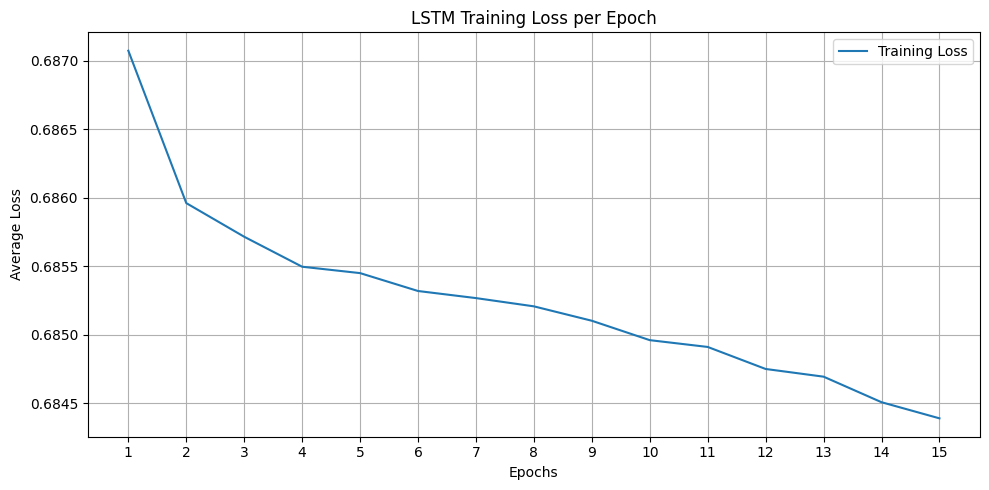

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('LSTM Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_epochs + 1)) # Ensure integer ticks for epochs
plt.tight_layout()
# Save the plot
plot_filename = 'training_loss.png'
plt.savefig(plot_filename)
print(f"Training loss plot saved to {plot_filename}")
plt.show()


In [36]:
y_pred_test, y_true_test, test_accuracy = evaluate_model(model, test_loader, criterion, device)

# Store accuracy for later use
test_accuracy_percentage = test_accuracy * 100


--- Starting Evaluation ---
Test Loss: 0.6969, Test Accuracy: 0.5247

Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.88      0.66    209713
         1.0       0.50      0.13      0.21    190277

    accuracy                           0.52    399990
   macro avg       0.51      0.51      0.43    399990
weighted avg       0.52      0.52      0.45    399990


Confusion Matrix:
[[184906  24807]
 [165328  24949]]
--- Evaluation Finished ---


In [37]:
model_save_path = 'bitcoin_lstm_model.pth'
print(f"\nSaving model state dictionary to {model_save_path}...")
torch.save(model.state_dict(), model_save_path)
print("Model saved successfully.")



Saving model state dictionary to bitcoin_lstm_model.pth...
Model saved successfully.


In [38]:
def get_probabilities(model, data_loader, device):
    """Generates model output probabilities for the given data loader."""
    model.eval() # Set to evaluation mode
    probabilities = []
    print("Generating prediction probabilities...")
    with torch.no_grad():
        for inputs, _ in data_loader: # We only need inputs from the loader
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze() # Get probabilities (remove extra dim)
            probabilities.extend(outputs.cpu().numpy())
    print("Probability generation complete.")
    return np.array(probabilities)

print("get_probabilities function defined.")

get_probabilities function defined.


In [39]:
def get_positions(probabilities, threshold_buy=0.6, threshold_sell=0.4):
    """Converts probabilities into trading positions."""
    # Ensure thresholds are valid
    if not (0 < threshold_sell < threshold_buy < 1):
        raise ValueError("Thresholds must satisfy 0 < threshold_sell < threshold_buy < 1")

    positions = np.zeros(len(probabilities)) # Default to neutral (0)
    positions[probabilities > threshold_buy] = 1  # Buy signal
    positions[probabilities < threshold_sell] = -1 # Sell signal
    print(f"Positions generated using thresholds: Buy > {threshold_buy}, Sell < {threshold_sell}")
    return positions

print("get_positions function defined.")

get_positions function defined.


In [40]:
y_pred_proba_test = get_probabilities(model, test_loader, device)

# Define thresholds for buy/sell signals
buy_threshold = 0.60 # Example: Buy if probability > 60%
sell_threshold = 0.40 # Example: Sell if probability < 40%

# Convert probabilities to trading signals/positions
test_positions = get_positions(y_pred_proba_test, threshold_buy=buy_threshold, threshold_sell=sell_threshold)

print(f"\nShape of test probabilities: {y_pred_proba_test.shape}")
print(f"Shape of test positions: {test_positions.shape}")
# Note: The number of predictions/positions is len(X_test) - time_steps

Generating prediction probabilities...
Probability generation complete.
Positions generated using thresholds: Buy > 0.6, Sell < 0.4

Shape of test probabilities: (399990,)
Shape of test positions: (399990,)


In [41]:
start_index_pred = train_size + time_steps
end_index_pred = start_index_pred + len(y_test_seq) # y_test_seq has same length as predictions

# Get the corresponding dates from the original DataFrame index
test_dates = df.index[start_index_pred:end_index_pred]

# Get the corresponding closing prices
# We need the prices at which the *outcome* of the prediction occurs
test_prices = df['Close'].iloc[start_index_pred:end_index_pred].values

# Ensure lengths match
if len(test_dates) != len(test_positions) or len(test_prices) != len(test_positions):
     print(f"Error: Length mismatch!")
     print(f" - Dates: {len(test_dates)}")
     print(f" - Prices: {len(test_prices)}")
     print(f" - Positions: {len(test_positions)}")
     raise ValueError("Length mismatch between dates/prices and positions for backtesting.")
else:
    print("Dates, prices, and positions aligned for backtesting.")
    print(f"Number of trading signals for simulation: {len(test_positions)}")

Dates, prices, and positions aligned for backtesting.
Number of trading signals for simulation: 399990


In [42]:
print("Calculating strategy returns...")
# Strategy returns: calculated based on the position held *before* the current price change
strategy_returns = np.zeros(len(test_positions))
for i in range(1, len(test_positions)):
    # Position taken based on prediction *before* time i-1, return realized between i-1 and i
    position_held = test_positions[i-1]
    price_prev = test_prices[i-1]
    price_curr = test_prices[i]

    if price_prev == 0: continue # Avoid division by zero if price data is bad

    if position_held == 1:  # If we were long
        strategy_returns[i] = (price_curr / price_prev) - 1
    elif position_held == -1: # If we were short (assuming short selling capability)
        strategy_returns[i] = (price_prev / price_curr) - 1 # Return is inverse price change
    # If position is 0 (neutral), return is 0

# Calculate cumulative returns (compounded)
# Add 1 for compounding calculation, then subtract 1 at the end
strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1

# Calculate Buy-and-Hold returns for the same period
buy_hold_returns = (test_prices / test_prices[0]) - 1 # Normalize by starting price

print("Return calculations complete.")


Calculating strategy returns...
Return calculations complete.


Strategy performance plot saved to strategy_performance.png


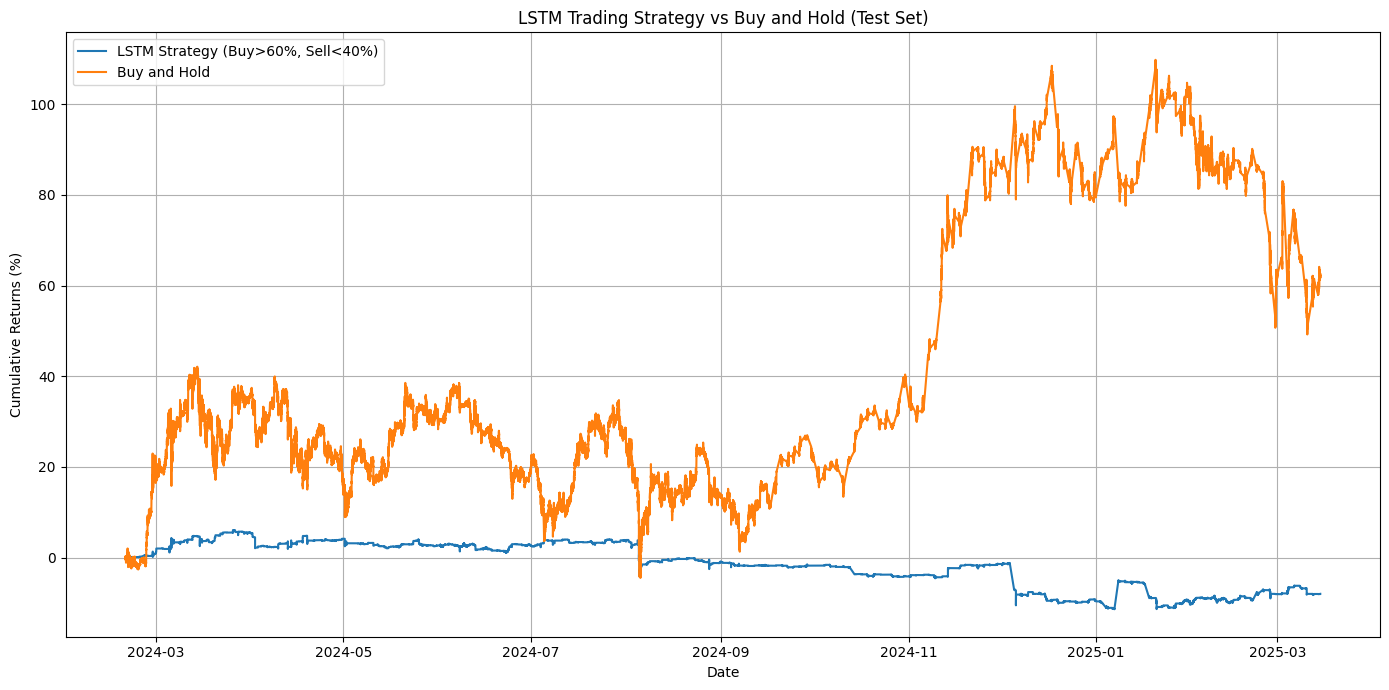

In [43]:
plt.figure(figsize=(14, 7))
plt.plot(test_dates, strategy_cumulative_returns * 100, label=f'LSTM Strategy (Buy>{buy_threshold*100:.0f}%, Sell<{sell_threshold*100:.0f}%)')
plt.plot(test_dates, buy_hold_returns * 100, label='Buy and Hold')
plt.title('LSTM Trading Strategy vs Buy and Hold (Test Set)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
perf_plot_filename = 'strategy_performance.png'
plt.savefig(perf_plot_filename)
print(f"Strategy performance plot saved to {perf_plot_filename}")
plt.show()

In [44]:
strategy_final_return = strategy_cumulative_returns[-1] * 100
buyhold_final_return = buy_hold_returns[-1] * 100

print("\n--- Trading Strategy Results ---")
print(f"Test Period Start Date: {test_dates[0]}")
print(f"Test Period End Date: {test_dates[-1]}")
print(f"\nLSTM Strategy Final Return: {strategy_final_return:.2f}%")
print(f"Buy and Hold Final Return:  {buyhold_final_return:.2f}%")

# Count buy/sell/neutral signals
num_buy = np.sum(test_positions == 1)
num_sell = np.sum(test_positions == -1)
num_neutral = np.sum(test_positions == 0)
total_signals = len(test_positions)

print("\nSignal Distribution:")
if total_signals > 0:
    print(f" - Total Buy signals:    {num_buy} ({num_buy/total_signals*100:.1f}%)")
    print(f" - Total Sell signals:   {num_sell} ({num_sell/total_signals*100:.1f}%)")
    print(f" - Total Neutral signals: {num_neutral} ({num_neutral/total_signals*100:.1f}%)")
else:
    print("No signals generated.")
print("--------------------------------")


--- Trading Strategy Results ---
Test Period Start Date: 2024-02-20 01:31:00
Test Period End Date: 2025-03-15 00:00:00

LSTM Strategy Final Return: -8.01%
Buy and Hold Final Return:  61.84%

Signal Distribution:
 - Total Buy signals:    535 (0.1%)
 - Total Sell signals:   14546 (3.6%)
 - Total Neutral signals: 384909 (96.2%)
--------------------------------


In [45]:
print("\n--- Simple Bitcoin Trading Strategy Guide ---")
print(f"1. Model looks back at the previous {time_steps} data points (e.g., minutes).")
print(f"2. Features used include: Price (OHLCV), Volume, Returns, MA5, MA20, MACD,")
print(f"   and potentially blockchain flow data ({', '.join([col for col in flow_features_to_add if col in feature_columns]) or 'None'}).")
print(f"3. Model predicts the probability of the price increasing in the next data point.")
print("4. Signal interpretation based on prediction probability (p):")
print(f"   - p > {buy_threshold:.2f} ({buy_threshold*100:.0f}%): Potential BUY signal")
print(f"   - p < {sell_threshold:.2f} ({sell_threshold*100:.0f}%): Potential SELL signal")
print(f"   - {sell_threshold:.2f} <= p <= {buy_threshold:.2f}: HOLD/NEUTRAL signal")
print(f"5. Model accuracy on test data: {test_accuracy_percentage:.2f}%")
print("\nDisclaimer: This is a simplified model for educational purposes. Past performance is not indicative of future results. Trading cryptocurrencies involves significant risk.")
print("-----------------------------------------")


--- Simple Bitcoin Trading Strategy Guide ---
1. Model looks back at the previous 10 data points (e.g., minutes).
2. Features used include: Price (OHLCV), Volume, Returns, MA5, MA20, MACD,
   and potentially blockchain flow data (flow_mean, flow_total, transactions_count_flow, regime).
3. Model predicts the probability of the price increasing in the next data point.
4. Signal interpretation based on prediction probability (p):
   - p > 0.60 (60%): Potential BUY signal
   - p < 0.40 (40%): Potential SELL signal
   - 0.40 <= p <= 0.60: HOLD/NEUTRAL signal
5. Model accuracy on test data: 52.47%

Disclaimer: This is a simplified model for educational purposes. Past performance is not indicative of future results. Trading cryptocurrencies involves significant risk.
-----------------------------------------


In [46]:
def predict_trade_signal(new_data_df, model, scaler, feature_columns, time_steps, device, threshold_buy=0.6, threshold_sell=0.4):
    """
    Predicts trading signals on new unseen data.

    Parameters:
    new_data_df (pd.DataFrame): DataFrame with index as Timestamp and required feature columns.
                                  Must have at least `time_steps` rows.
                                  Should be preprocessed similarly to training data (NaNs handled, features calculated).
    model (nn.Module): The trained PyTorch LSTM model.
    scaler (StandardScaler): The scaler fitted on the training data.
    feature_columns (list): List of feature names model was trained on.
    time_steps (int): The sequence length model expects.
    device (torch.device): 'cpu' or 'cuda'.
    threshold_buy (float): Probability threshold for buy signal.
    threshold_sell (float): Probability threshold for sell signal.

    Returns:
    tuple: (last_probability, last_signal)
           - last_probability (float): Probability prediction for the *next* timestep after the input data.
           - last_signal (int): Trading signal (1=buy, -1=sell, 0=neutral) for the *next* timestep.
           Returns (None, None) if input data is insufficient.
    """
    print("\n--- Predicting on New Data ---")
    if len(new_data_df) < time_steps:
        print(f"Error: Need at least {time_steps} rows of new data, but got {len(new_data_df)}.")
        return None, None

    # Ensure required columns exist
    missing_cols = [col for col in feature_columns if col not in new_data_df.columns]
    if missing_cols:
        print(f"Error: New data is missing required columns: {missing_cols}")
        return None, None

    # Prepare features from the *last* `time_steps` rows
    X_new = new_data_df[feature_columns].iloc[-time_steps:].values

    # Check for NaNs in the selected data slice
    if np.isnan(X_new).any():
         print(f"Error: NaNs detected in the last {time_steps} rows of the new data's features.")
         # print(new_data_df[feature_columns].iloc[-time_steps:].isna().sum()) # Optional: show details
         return None, None

    # Scale features using the *original* scaler
    X_new_scaled = scaler.transform(X_new) # Use transform, not fit_transform

    # Create a single sequence
    X_new_seq = np.array([X_new_scaled]) # Shape: (1, time_steps, n_features)
    X_new_tensor = torch.FloatTensor(X_new_seq).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        probability = model(X_new_tensor).squeeze().cpu().item() # Get single probability value

    # Get position based on probability
    position = 0
    if probability > threshold_buy:
        position = 1
    elif probability < threshold_sell:
        position = -1

    print(f"Prediction for next timestep: Probability={probability:.4f}, Signal={position}")
    print("-----------------------------")
    return probability, position

print("predict_trade_signal function defined.")

predict_trade_signal function defined.


In [47]:
print("\n--- Example: Using the model for a new prediction ---")
# 1. Load new data (replace with your actual new data loading)
try:
    # Example: Load the last few rows from the original data as 'new' data
    # In reality, this would be fresh data not seen during training/testing
    num_new_rows = 50 # Need at least time_steps rows
    if len(df) >= num_new_rows: # Check if we have enough data in the original df for demo
        new_data_raw = df.iloc[-num_new_rows:].copy() # Create a copy to avoid modifying original df
        print(f"Loaded last {num_new_rows} rows as 'new_data_raw' for demonstration.")

        # 2. Preprocess the new data *exactly* like the training data
        #    - Ensure correct dtypes, handle NaNs (ffill first, then 0)
        #    - Calculate ALL the same features ('Returns', 'MA5', 'MA20', 'MACD', 'MACD_Signal', etc.)
        #    - Handle NaNs resulting from feature calculations (ffill, bfill, 0)
        #    *This step is crucial and must replicate Cells 5, 6, 7 accurately*
        #    (For this demo, we assume the data loaded already has these features calculated
        #     and NaNs handled up to the point before the prediction function,
        #     as it came from the already processed `df`)

        # Check if preprocessing was successful (no NaNs in needed features)
        if new_data_raw[feature_columns].iloc[-time_steps:].isna().sum().sum() == 0:
            print("Preprocessing assumed complete for demo data.")

            # 3. Make prediction using the last `time_steps` rows
            probability, signal = predict_trade_signal(
                new_data_df=new_data_raw,
                model=model,
                scaler=scaler, # Use the scaler fitted during training
                feature_columns=feature_columns,
                time_steps=time_steps,
                device=device,
                threshold_buy=buy_threshold,
                threshold_sell=sell_threshold
            )

            # 4. Interpret the signal for the *next* time step
            if signal is not None:
                print("\nPredicted Trading Action for the next time step:")
                if signal == 1:
                    print("  >> BUY")
                elif signal == -1:
                    print("  >> SELL")
                else:
                    print("  >> HOLD / NEUTRAL")
            else:
                print("\nPrediction failed due to data issues.")

        else:
             print("\nDemo data still contains NaNs after simulated preprocessing. Cannot predict.")
             print(new_data_raw[feature_columns].iloc[-time_steps:].isna().sum())

    else:
        print(f"\nNot enough data in 'df' ({len(df)} rows) to create a demo sample of size {num_new_rows}.")


except NameError:
    print("\nVariable 'df' not defined. Run previous cells first.")
except Exception as e:
    print(f"\nAn error occurred during the example prediction: {e}")
    import traceback
    traceback.print_exc()

print("----------------------------------------------------")
print("\nLSTM model notebook execution complete!")



--- Example: Using the model for a new prediction ---
Loaded last 50 rows as 'new_data_raw' for demonstration.
Preprocessing assumed complete for demo data.

--- Predicting on New Data ---
Prediction for next timestep: Probability=0.4489, Signal=0
-----------------------------

Predicted Trading Action for the next time step:
  >> HOLD / NEUTRAL
----------------------------------------------------

LSTM model notebook execution complete!
